In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [4]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch
import json

# Embeddings Experiment

### Loading embeddings

In [7]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []
loaded_hallucination_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        loaded_hallucination_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))


In [79]:
monofact_embeddings = []
hallucination_embeddings = []
normal_fact_embeddings = []
all_embeddings = []
embedding_of = []

for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))
    all_embeddings.append(torch.tensor(loaded_normal_fact_embedding))
    embedding_of.append('Popular fact')
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
    all_embeddings.append(torch.tensor(loaded_monofact_embedding))
    embedding_of.append('Monofact')
for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
    hallucination_embeddings.append((loaded_hallucination, torch.tensor(loaded_hallucination_embedding)))
    all_embeddings.append(torch.tensor(loaded_hallucination_embedding))
    embedding_of.append('Hallucination')

In [80]:
all_embeddings = torch.cat([a.unsqueeze(0) for a in all_embeddings])

In [81]:
monofact_embeddings[0][1].shape

torch.Size([1536])

In [82]:
torch.cuda.empty_cache()

In [83]:
all_embeddings.shape

torch.Size([834, 1536])

In [84]:
all_embeddings_numpy = all_embeddings.detach().numpy()

In [85]:
all_embeddings_numpy

array([[ 0.5362337 , -0.03913231,  4.460196  , ...,  1.669704  ,
        -1.2950296 ,  0.02972578],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.03552325,
         3.2620003 ,  0.0574283 ],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.15969001,
        -1.3031412 ,  1.4547727 ],
       ...,
       [ 0.5362337 , -0.03913231,  4.460196  , ..., -0.08100768,
         3.340527  ,  0.17142652],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.2333981 ,
        -1.3022641 , -0.12915558],
       [ 0.5362337 , -0.03913231,  4.460196  , ..., -0.1235887 ,
        -2.9214263 ,  0.42203456]], dtype=float32)

In [86]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(all_embeddings_numpy)
X_embedded.shape

(834, 2)

In [87]:
import matplotlib.pyplot as plt

In [88]:
colors = {
    'Hallucination': 'red',
    'Popular fact': 'lightblue',
    'Monofact': 'purple'
}

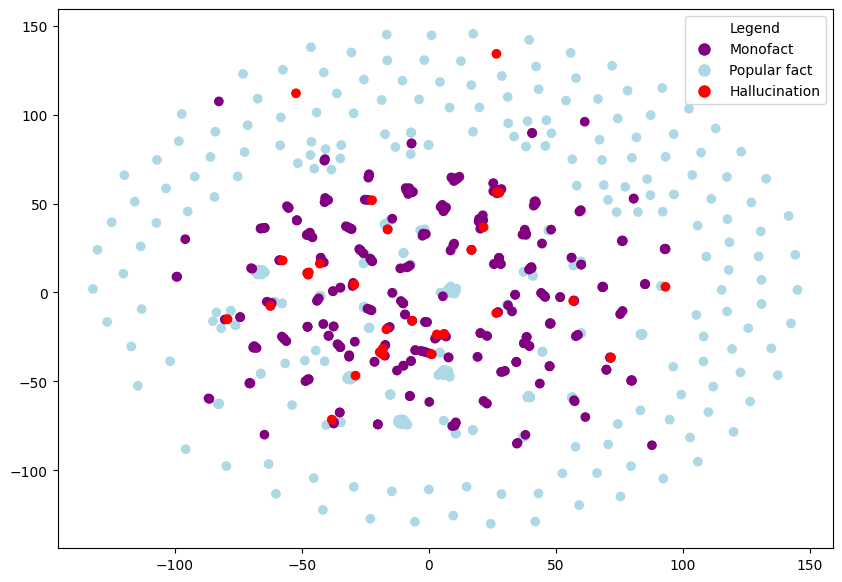

In [95]:
unique_labels = set(embedding_of)
label_color_map = {label: colors[label] for label in unique_labels}

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[c] for c in embedding_of])

# Create a list of handles (proxy artists) for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for label, color in label_color_map.items()]
labels = list(label_color_map.keys())

# Add legend to the plot
plt.legend(handles, labels, title="Legend")

# Show the plot
plt.savefig('figure.png', dpi=500)
plt.show()

In [102]:
from numpy import dot
import numpy as np
from numpy.linalg import norm

def dist(tensor_a, tensor_b):
    a = tensor_a.detach().numpy()
    b = tensor_b.detach().numpy()
    # return dot(a, b)/(norm(a)*norm(b))
    return np.linalg.norm(a-b)

In [135]:
def closest_different_point(embedding, top_k = 3):
    smallest_dist = 1E9
    result = None

    distances = []
    
    for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
        mf_embedding = torch.tensor(loaded_monofact_embedding)

        d = dist(embedding, mf_embedding)
        distances.append({'dist': d, 'type': 'Monofact'})
    for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
        hf_embedding = torch.tensor(loaded_hallucination_embedding)

        d = dist(embedding, hf_embedding)
        distances.append({'dist': d, 'type': 'Hallucination'})

    for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
        nf_embedding = torch.tensor(loaded_normal_fact_embedding)

        d = dist(embedding, nf_embedding)
        distances.append({'dist': d, 'type': 'Popular Fact'})

    return pd.DataFrame(distances).sort_values(by='dist').reset_index(drop=True)['type'].iloc[1:(top_k + 1)].value_counts()

In [136]:
from tqdm import tqdm

In [138]:
result = []

for i, point_type in tqdm(enumerate(embedding_of)):
    embedding = all_embeddings[i]
    closest = dict(closest_different_point(embedding))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = point_type

    print(i, point_type, closest)

    result.append(closest_point)

2it [00:00,  6.11it/s]

0 Popular fact {'Monofact': 2, 'Popular Fact': 1}
1 Popular fact {'Popular Fact': 3}


4it [00:00,  6.17it/s]

2 Popular fact {'Popular Fact': 3}
3 Popular fact {'Popular Fact': 3}


6it [00:00,  6.15it/s]

4 Popular fact {'Popular Fact': 3}
5 Popular fact {'Popular Fact': 3}


8it [00:01,  6.15it/s]

6 Popular fact {'Popular Fact': 2, 'Monofact': 1}
7 Popular fact {'Monofact': 2, 'Popular Fact': 1}


10it [00:01,  6.19it/s]

8 Popular fact {'Popular Fact': 3}
9 Popular fact {'Popular Fact': 3}


12it [00:01,  6.14it/s]

10 Popular fact {'Popular Fact': 3}
11 Popular fact {'Monofact': 2, 'Popular Fact': 1}


14it [00:02,  6.17it/s]

12 Popular fact {'Popular Fact': 2, 'Monofact': 1}
13 Popular fact {'Popular Fact': 2, 'Monofact': 1}


16it [00:02,  6.19it/s]

14 Popular fact {'Popular Fact': 3}
15 Popular fact {'Popular Fact': 3}


18it [00:02,  6.20it/s]

16 Popular fact {'Popular Fact': 3}
17 Popular fact {'Popular Fact': 3}


20it [00:03,  6.02it/s]

18 Popular fact {'Popular Fact': 3}
19 Popular fact {'Popular Fact': 3}


22it [00:03,  6.05it/s]

20 Popular fact {'Popular Fact': 3}
21 Popular fact {'Popular Fact': 2, 'Monofact': 1}


24it [00:03,  6.08it/s]

22 Popular fact {'Popular Fact': 3}
23 Popular fact {'Popular Fact': 3}


26it [00:04,  6.19it/s]

24 Popular fact {'Popular Fact': 3}
25 Popular fact {'Popular Fact': 3}


28it [00:04,  6.24it/s]

26 Popular fact {'Popular Fact': 3}
27 Popular fact {'Popular Fact': 3}


30it [00:04,  6.26it/s]

28 Popular fact {'Popular Fact': 2, 'Monofact': 1}
29 Popular fact {'Popular Fact': 2, 'Monofact': 1}


32it [00:05,  5.91it/s]

30 Popular fact {'Popular Fact': 3}
31 Popular fact {'Monofact': 2, 'Popular Fact': 1}


34it [00:05,  6.08it/s]

32 Popular fact {'Popular Fact': 3}
33 Popular fact {'Popular Fact': 3}


36it [00:05,  6.19it/s]

34 Popular fact {'Popular Fact': 3}
35 Popular fact {'Popular Fact': 3}


38it [00:06,  6.24it/s]

36 Popular fact {'Popular Fact': 2, 'Monofact': 1}
37 Popular fact {'Popular Fact': 3}


40it [00:06,  6.24it/s]

38 Popular fact {'Popular Fact': 3}
39 Popular fact {'Monofact': 2, 'Popular Fact': 1}


42it [00:06,  6.27it/s]

40 Popular fact {'Popular Fact': 3}
41 Popular fact {'Popular Fact': 3}


44it [00:07,  6.27it/s]

42 Popular fact {'Popular Fact': 3}
43 Popular fact {'Popular Fact': 3}


46it [00:07,  6.29it/s]

44 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}
45 Popular fact {'Popular Fact': 2, 'Monofact': 1}


48it [00:07,  6.28it/s]

46 Popular fact {'Popular Fact': 3}
47 Popular fact {'Popular Fact': 3}


50it [00:08,  6.28it/s]

48 Popular fact {'Popular Fact': 3}
49 Popular fact {'Popular Fact': 3}


52it [00:08,  6.18it/s]

50 Popular fact {'Popular Fact': 2, 'Monofact': 1}
51 Popular fact {'Popular Fact': 3}


54it [00:08,  6.24it/s]

52 Popular fact {'Popular Fact': 3}
53 Popular fact {'Popular Fact': 3}


56it [00:09,  6.27it/s]

54 Popular fact {'Popular Fact': 3}
55 Popular fact {'Popular Fact': 3}


58it [00:09,  6.28it/s]

56 Popular fact {'Popular Fact': 3}
57 Popular fact {'Popular Fact': 2, 'Monofact': 1}


60it [00:09,  6.25it/s]

58 Popular fact {'Popular Fact': 3}
59 Popular fact {'Popular Fact': 2, 'Monofact': 1}


62it [00:10,  6.07it/s]

60 Popular fact {'Popular Fact': 3}
61 Popular fact {'Popular Fact': 3}


64it [00:10,  5.86it/s]

62 Popular fact {'Popular Fact': 3}
63 Popular fact {'Popular Fact': 3}


65it [00:10,  5.72it/s]

64 Popular fact {'Popular Fact': 3}


66it [00:10,  4.86it/s]

65 Popular fact {'Popular Fact': 3}


68it [00:11,  4.96it/s]

66 Popular fact {'Popular Fact': 3}
67 Popular fact {'Popular Fact': 3}


70it [00:11,  5.30it/s]

68 Popular fact {'Popular Fact': 3}
69 Popular fact {'Popular Fact': 3}


72it [00:11,  5.75it/s]

70 Popular fact {'Popular Fact': 3}
71 Popular fact {'Popular Fact': 2, 'Monofact': 1}


74it [00:12,  5.71it/s]

72 Popular fact {'Popular Fact': 3}
73 Popular fact {'Popular Fact': 3}


76it [00:12,  5.99it/s]

74 Popular fact {'Popular Fact': 3}
75 Popular fact {'Popular Fact': 3}


78it [00:12,  6.17it/s]

76 Popular fact {'Popular Fact': 2, 'Monofact': 1}
77 Popular fact {'Popular Fact': 3}


80it [00:13,  6.25it/s]

78 Popular fact {'Popular Fact': 3}
79 Popular fact {'Monofact': 2, 'Popular Fact': 1}


82it [00:13,  6.27it/s]

80 Popular fact {'Popular Fact': 3}
81 Popular fact {'Popular Fact': 3}


84it [00:13,  5.97it/s]

82 Popular fact {'Popular Fact': 3}
83 Popular fact {'Popular Fact': 3}


86it [00:14,  6.00it/s]

84 Popular fact {'Popular Fact': 2, 'Monofact': 1}
85 Popular fact {'Monofact': 2, 'Popular Fact': 1}


88it [00:14,  6.00it/s]

86 Popular fact {'Popular Fact': 3}
87 Popular fact {'Popular Fact': 3}


90it [00:14,  6.10it/s]

88 Popular fact {'Popular Fact': 3}
89 Popular fact {'Popular Fact': 3}


92it [00:15,  6.09it/s]

90 Popular fact {'Popular Fact': 3}
91 Popular fact {'Popular Fact': 3}


94it [00:15,  6.17it/s]

92 Popular fact {'Popular Fact': 3}
93 Popular fact {'Popular Fact': 3}


96it [00:15,  6.21it/s]

94 Popular fact {'Popular Fact': 3}
95 Popular fact {'Popular Fact': 2, 'Monofact': 1}


98it [00:16,  6.24it/s]

96 Popular fact {'Popular Fact': 3}
97 Popular fact {'Popular Fact': 3}


100it [00:16,  6.16it/s]

98 Popular fact {'Popular Fact': 3}
99 Popular fact {'Popular Fact': 3}


102it [00:16,  6.22it/s]

100 Popular fact {'Popular Fact': 3}
101 Popular fact {'Popular Fact': 3}


104it [00:17,  6.10it/s]

102 Popular fact {'Popular Fact': 3}
103 Popular fact {'Popular Fact': 3}


106it [00:17,  6.18it/s]

104 Popular fact {'Popular Fact': 3}
105 Popular fact {'Popular Fact': 3}


108it [00:17,  6.28it/s]

106 Popular fact {'Popular Fact': 3}
107 Popular fact {'Popular Fact': 3}


110it [00:18,  6.26it/s]

108 Popular fact {'Popular Fact': 3}
109 Popular fact {'Popular Fact': 3}


112it [00:18,  6.31it/s]

110 Popular fact {'Popular Fact': 2, 'Monofact': 1}
111 Popular fact {'Popular Fact': 2, 'Monofact': 1}


114it [00:18,  6.33it/s]

112 Popular fact {'Popular Fact': 2, 'Monofact': 1}
113 Popular fact {'Popular Fact': 3}


116it [00:19,  6.33it/s]

114 Popular fact {'Popular Fact': 3}
115 Popular fact {'Popular Fact': 2, 'Monofact': 1}


118it [00:19,  6.34it/s]

116 Popular fact {'Popular Fact': 3}
117 Popular fact {'Popular Fact': 3}


120it [00:19,  6.32it/s]

118 Popular fact {'Popular Fact': 2, 'Monofact': 1}
119 Popular fact {'Popular Fact': 3}


122it [00:20,  6.35it/s]

120 Popular fact {'Popular Fact': 3}
121 Popular fact {'Popular Fact': 3}


124it [00:20,  6.35it/s]

122 Popular fact {'Popular Fact': 3}
123 Popular fact {'Popular Fact': 3}


126it [00:20,  6.15it/s]

124 Popular fact {'Popular Fact': 3}
125 Popular fact {'Popular Fact': 3}


128it [00:20,  6.17it/s]

126 Popular fact {'Popular Fact': 3}
127 Popular fact {'Popular Fact': 2, 'Monofact': 1}


130it [00:21,  6.23it/s]

128 Popular fact {'Popular Fact': 2, 'Monofact': 1}
129 Popular fact {'Popular Fact': 3}


132it [00:21,  6.24it/s]

130 Popular fact {'Popular Fact': 3}
131 Popular fact {'Popular Fact': 3}


134it [00:21,  6.27it/s]

132 Popular fact {'Popular Fact': 3}
133 Popular fact {'Popular Fact': 2, 'Monofact': 1}


136it [00:22,  6.24it/s]

134 Popular fact {'Popular Fact': 3}
135 Popular fact {'Monofact': 2, 'Popular Fact': 1}


138it [00:22,  6.26it/s]

136 Popular fact {'Popular Fact': 3}
137 Popular fact {'Popular Fact': 3}


140it [00:22,  6.30it/s]

138 Popular fact {'Popular Fact': 3}
139 Popular fact {'Popular Fact': 2, 'Monofact': 1}


142it [00:23,  6.33it/s]

140 Popular fact {'Popular Fact': 3}
141 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}


144it [00:23,  6.10it/s]

142 Popular fact {'Popular Fact': 3}
143 Popular fact {'Popular Fact': 3}


146it [00:23,  6.15it/s]

144 Popular fact {'Popular Fact': 3}
145 Popular fact {'Popular Fact': 3}


148it [00:24,  6.23it/s]

146 Popular fact {'Popular Fact': 3}
147 Popular fact {'Popular Fact': 2, 'Monofact': 1}


150it [00:24,  6.27it/s]

148 Popular fact {'Popular Fact': 3}
149 Popular fact {'Popular Fact': 3}


152it [00:24,  6.28it/s]

150 Popular fact {'Monofact': 2, 'Popular Fact': 1}
151 Popular fact {'Popular Fact': 3}


154it [00:25,  6.30it/s]

152 Popular fact {'Monofact': 2, 'Popular Fact': 1}
153 Popular fact {'Popular Fact': 3}


156it [00:25,  6.14it/s]

154 Popular fact {'Popular Fact': 3}
155 Popular fact {'Popular Fact': 3}


158it [00:25,  6.23it/s]

156 Popular fact {'Popular Fact': 3}
157 Popular fact {'Popular Fact': 3}


160it [00:26,  6.29it/s]

158 Popular fact {'Popular Fact': 3}
159 Popular fact {'Popular Fact': 3}


162it [00:26,  5.90it/s]

160 Popular fact {'Popular Fact': 3}
161 Popular fact {'Popular Fact': 3}


164it [00:26,  6.12it/s]

162 Popular fact {'Popular Fact': 3}
163 Popular fact {'Popular Fact': 3}


166it [00:27,  6.22it/s]

164 Popular fact {'Popular Fact': 3}
165 Popular fact {'Popular Fact': 3}


168it [00:27,  6.27it/s]

166 Popular fact {'Popular Fact': 3}
167 Popular fact {'Popular Fact': 3}


170it [00:27,  6.16it/s]

168 Popular fact {'Popular Fact': 3}
169 Popular fact {'Popular Fact': 3}


172it [00:28,  6.24it/s]

170 Popular fact {'Popular Fact': 3}
171 Popular fact {'Popular Fact': 2, 'Monofact': 1}


174it [00:28,  6.29it/s]

172 Popular fact {'Popular Fact': 2, 'Monofact': 1}
173 Popular fact {'Popular Fact': 3}


176it [00:28,  6.29it/s]

174 Popular fact {'Popular Fact': 2, 'Monofact': 1}
175 Popular fact {'Popular Fact': 3}


178it [00:29,  6.18it/s]

176 Popular fact {'Popular Fact': 3}
177 Popular fact {'Popular Fact': 3}


180it [00:29,  6.18it/s]

178 Popular fact {'Popular Fact': 2, 'Monofact': 1}
179 Popular fact {'Popular Fact': 3}


182it [00:29,  6.24it/s]

180 Popular fact {'Monofact': 2, 'Popular Fact': 1}
181 Popular fact {'Popular Fact': 3}


184it [00:29,  6.25it/s]

182 Popular fact {'Popular Fact': 3}
183 Popular fact {'Popular Fact': 3}


186it [00:30,  6.31it/s]

184 Popular fact {'Popular Fact': 3}
185 Popular fact {'Popular Fact': 3}


188it [00:30,  6.31it/s]

186 Popular fact {'Popular Fact': 3}
187 Popular fact {'Popular Fact': 3}


190it [00:30,  6.13it/s]

188 Popular fact {'Popular Fact': 3}
189 Popular fact {'Popular Fact': 3}


192it [00:31,  6.25it/s]

190 Popular fact {'Popular Fact': 3}
191 Popular fact {'Monofact': 2, 'Popular Fact': 1}


194it [00:31,  6.29it/s]

192 Popular fact {'Popular Fact': 3}
193 Popular fact {'Popular Fact': 3}


196it [00:31,  6.30it/s]

194 Popular fact {'Popular Fact': 3}
195 Popular fact {'Popular Fact': 3}


198it [00:32,  6.33it/s]

196 Popular fact {'Popular Fact': 3}
197 Popular fact {'Popular Fact': 3}


200it [00:32,  6.34it/s]

198 Popular fact {'Popular Fact': 3}
199 Popular fact {'Popular Fact': 3}


202it [00:32,  6.33it/s]

200 Popular fact {'Popular Fact': 3}
201 Popular fact {'Popular Fact': 3}


204it [00:33,  6.35it/s]

202 Popular fact {'Popular Fact': 3}
203 Popular fact {'Popular Fact': 3}


206it [00:33,  6.35it/s]

204 Popular fact {'Popular Fact': 2, 'Monofact': 1}
205 Popular fact {'Popular Fact': 3}


208it [00:33,  6.33it/s]

206 Popular fact {'Popular Fact': 2, 'Monofact': 1}
207 Popular fact {'Popular Fact': 3}


210it [00:34,  6.34it/s]

208 Popular fact {'Popular Fact': 3}
209 Popular fact {'Popular Fact': 3}


212it [00:34,  6.35it/s]

210 Popular fact {'Popular Fact': 3}
211 Popular fact {'Popular Fact': 3}


214it [00:34,  6.33it/s]

212 Popular fact {'Popular Fact': 3}
213 Popular fact {'Popular Fact': 3}


216it [00:35,  6.34it/s]

214 Popular fact {'Popular Fact': 3}
215 Popular fact {'Monofact': 2, 'Popular Fact': 1}


218it [00:35,  6.34it/s]

216 Popular fact {'Popular Fact': 3}
217 Popular fact {'Popular Fact': 2, 'Monofact': 1}


220it [00:35,  5.98it/s]

218 Popular fact {'Monofact': 2, 'Popular Fact': 1}
219 Popular fact {'Popular Fact': 3}


222it [00:36,  6.17it/s]

220 Popular fact {'Popular Fact': 1, 'Hallucination': 1, 'Monofact': 1}
221 Popular fact {'Popular Fact': 3}


224it [00:36,  6.28it/s]

222 Popular fact {'Popular Fact': 3}
223 Popular fact {'Popular Fact': 3}


226it [00:36,  6.31it/s]

224 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}
225 Popular fact {'Popular Fact': 3}


228it [00:36,  6.33it/s]

226 Popular fact {'Popular Fact': 3}
227 Popular fact {'Popular Fact': 3}


230it [00:37,  6.32it/s]

228 Popular fact {'Monofact': 2, 'Popular Fact': 1}
229 Popular fact {'Popular Fact': 3}


232it [00:37,  6.35it/s]

230 Popular fact {'Popular Fact': 3}
231 Popular fact {'Popular Fact': 3}


234it [00:37,  6.33it/s]

232 Popular fact {'Popular Fact': 3}
233 Popular fact {'Popular Fact': 3}


236it [00:38,  6.35it/s]

234 Popular fact {'Popular Fact': 3}
235 Popular fact {'Popular Fact': 3}


238it [00:38,  6.35it/s]

236 Popular fact {'Popular Fact': 3}
237 Popular fact {'Popular Fact': 2, 'Monofact': 1}


240it [00:38,  6.34it/s]

238 Popular fact {'Popular Fact': 2, 'Monofact': 1}
239 Popular fact {'Popular Fact': 3}


242it [00:39,  6.33it/s]

240 Popular fact {'Popular Fact': 3}
241 Popular fact {'Popular Fact': 3}


244it [00:39,  6.33it/s]

242 Popular fact {'Popular Fact': 3}
243 Popular fact {'Popular Fact': 3}


246it [00:39,  6.34it/s]

244 Popular fact {'Popular Fact': 3}
245 Popular fact {'Popular Fact': 3}


248it [00:40,  6.34it/s]

246 Popular fact {'Popular Fact': 3}
247 Popular fact {'Popular Fact': 3}


250it [00:40,  6.35it/s]

248 Popular fact {'Popular Fact': 3}
249 Popular fact {'Popular Fact': 2, 'Monofact': 1}


252it [00:40,  6.33it/s]

250 Popular fact {'Popular Fact': 3}
251 Popular fact {'Popular Fact': 3}


254it [00:41,  6.35it/s]

252 Popular fact {'Popular Fact': 3}
253 Popular fact {'Popular Fact': 3}


256it [00:41,  6.35it/s]

254 Popular fact {'Popular Fact': 3}
255 Popular fact {'Popular Fact': 1, 'Hallucination': 1, 'Monofact': 1}


258it [00:41,  6.34it/s]

256 Popular fact {'Popular Fact': 3}
257 Popular fact {'Popular Fact': 2, 'Monofact': 1}


260it [00:42,  6.34it/s]

258 Popular fact {'Popular Fact': 3}
259 Popular fact {'Popular Fact': 3}


262it [00:42,  6.36it/s]

260 Popular fact {'Popular Fact': 2, 'Monofact': 1}
261 Popular fact {'Popular Fact': 3}


264it [00:42,  6.26it/s]

262 Popular fact {'Monofact': 2, 'Popular Fact': 1}
263 Popular fact {'Popular Fact': 3}


266it [00:42,  6.32it/s]

264 Popular fact {'Popular Fact': 3}
265 Popular fact {'Popular Fact': 3}


268it [00:43,  6.34it/s]

266 Popular fact {'Popular Fact': 3}
267 Popular fact {'Popular Fact': 3}


270it [00:43,  6.28it/s]

268 Popular fact {'Monofact': 2, 'Popular Fact': 1}
269 Popular fact {'Popular Fact': 3}


272it [00:43,  6.32it/s]

270 Popular fact {'Popular Fact': 3}
271 Popular fact {'Popular Fact': 3}


274it [00:44,  6.34it/s]

272 Popular fact {'Popular Fact': 3}
273 Popular fact {'Popular Fact': 3}


276it [00:44,  6.30it/s]

274 Popular fact {'Popular Fact': 3}
275 Popular fact {'Popular Fact': 3}


278it [00:44,  6.30it/s]

276 Popular fact {'Popular Fact': 3}
277 Popular fact {'Popular Fact': 2, 'Monofact': 1}


280it [00:45,  6.29it/s]

278 Popular fact {'Popular Fact': 3}
279 Popular fact {'Popular Fact': 3}


282it [00:45,  6.09it/s]

280 Popular fact {'Popular Fact': 3}
281 Popular fact {'Monofact': 2, 'Popular Fact': 1}


284it [00:45,  6.19it/s]

282 Popular fact {'Popular Fact': 3}
283 Popular fact {'Popular Fact': 3}


286it [00:46,  6.22it/s]

284 Popular fact {'Monofact': 2, 'Popular Fact': 1}
285 Popular fact {'Popular Fact': 3}


288it [00:46,  6.09it/s]

286 Popular fact {'Popular Fact': 3}
287 Popular fact {'Popular Fact': 3}


290it [00:46,  6.12it/s]

288 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}
289 Popular fact {'Popular Fact': 3}


292it [00:47,  6.25it/s]

290 Popular fact {'Popular Fact': 3}
291 Popular fact {'Popular Fact': 3}


294it [00:47,  6.26it/s]

292 Popular fact {'Popular Fact': 3}
293 Popular fact {'Popular Fact': 3}


296it [00:47,  6.32it/s]

294 Popular fact {'Popular Fact': 3}
295 Popular fact {'Popular Fact': 3}


298it [00:48,  6.31it/s]

296 Popular fact {'Popular Fact': 3}
297 Popular fact {'Popular Fact': 3}


300it [00:48,  6.34it/s]

298 Popular fact {'Popular Fact': 3}
299 Popular fact {'Monofact': 2, 'Popular Fact': 1}


302it [00:48,  6.33it/s]

300 Popular fact {'Popular Fact': 3}
301 Popular fact {'Popular Fact': 3}


304it [00:49,  6.36it/s]

302 Popular fact {'Popular Fact': 3}
303 Popular fact {'Popular Fact': 3}


306it [00:49,  6.31it/s]

304 Popular fact {'Monofact': 2, 'Popular Fact': 1}
305 Popular fact {'Popular Fact': 3}


308it [00:49,  6.30it/s]

306 Popular fact {'Popular Fact': 3}
307 Popular fact {'Popular Fact': 3}


310it [00:49,  6.29it/s]

308 Popular fact {'Popular Fact': 3}
309 Popular fact {'Popular Fact': 3}


312it [00:50,  6.23it/s]

310 Popular fact {'Popular Fact': 3}
311 Popular fact {'Popular Fact': 3}


314it [00:50,  6.28it/s]

312 Popular fact {'Popular Fact': 2, 'Monofact': 1}
313 Popular fact {'Popular Fact': 3}


316it [00:50,  6.30it/s]

314 Popular fact {'Popular Fact': 2, 'Monofact': 1}
315 Popular fact {'Monofact': 2, 'Popular Fact': 1}


318it [00:51,  6.31it/s]

316 Popular fact {'Popular Fact': 3}
317 Popular fact {'Monofact': 2, 'Popular Fact': 1}


320it [00:51,  6.30it/s]

318 Popular fact {'Popular Fact': 3}
319 Popular fact {'Popular Fact': 3}


322it [00:51,  6.34it/s]

320 Popular fact {'Popular Fact': 3}
321 Popular fact {'Popular Fact': 3}


324it [00:52,  6.33it/s]

322 Popular fact {'Popular Fact': 3}
323 Popular fact {'Popular Fact': 2, 'Monofact': 1}


326it [00:52,  6.27it/s]

324 Popular fact {'Popular Fact': 2, 'Monofact': 1}
325 Popular fact {'Popular Fact': 3}


328it [00:52,  6.26it/s]

326 Popular fact {'Popular Fact': 3}
327 Popular fact {'Popular Fact': 2, 'Monofact': 1}


330it [00:53,  6.04it/s]

328 Popular fact {'Popular Fact': 3}
329 Popular fact {'Popular Fact': 3}


331it [00:53,  5.87it/s]

330 Popular fact {'Popular Fact': 2, 'Monofact': 1}


333it [00:53,  5.34it/s]

331 Popular fact {'Popular Fact': 3}
332 Popular fact {'Popular Fact': 3}


335it [00:54,  5.49it/s]

333 Popular fact {'Popular Fact': 3}
334 Popular fact {'Popular Fact': 3}


337it [00:54,  5.41it/s]

335 Popular fact {'Popular Fact': 3}
336 Popular fact {'Popular Fact': 3}


339it [00:54,  5.54it/s]

337 Popular fact {'Popular Fact': 3}
338 Popular fact {'Popular Fact': 2, 'Monofact': 1}


341it [00:55,  5.64it/s]

339 Popular fact {'Popular Fact': 3}
340 Popular fact {'Popular Fact': 3}


343it [00:55,  5.68it/s]

341 Popular fact {'Popular Fact': 3}
342 Popular fact {'Popular Fact': 3}


345it [00:55,  5.88it/s]

343 Popular fact {'Popular Fact': 3}
344 Popular fact {'Popular Fact': 2, 'Monofact': 1}


347it [00:56,  5.93it/s]

345 Popular fact {'Popular Fact': 3}
346 Popular fact {'Popular Fact': 3}


349it [00:56,  5.95it/s]

347 Popular fact {'Popular Fact': 2, 'Monofact': 1}
348 Popular fact {'Popular Fact': 3}


351it [00:56,  5.67it/s]

349 Popular fact {'Popular Fact': 3}
350 Popular fact {'Popular Fact': 3}


353it [00:57,  5.46it/s]

351 Popular fact {'Popular Fact': 3}
352 Popular fact {'Popular Fact': 3}


355it [00:57,  5.56it/s]

353 Popular fact {'Popular Fact': 3}
354 Popular fact {'Popular Fact': 3}


357it [00:58,  5.72it/s]

355 Popular fact {'Popular Fact': 3}
356 Popular fact {'Popular Fact': 3}


359it [00:58,  5.90it/s]

357 Popular fact {'Monofact': 2, 'Popular Fact': 1}
358 Popular fact {'Popular Fact': 2, 'Monofact': 1}


361it [00:58,  6.06it/s]

359 Popular fact {'Popular Fact': 3}
360 Popular fact {'Popular Fact': 3}


363it [00:58,  6.15it/s]

361 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}
362 Popular fact {'Popular Fact': 3}


365it [00:59,  6.21it/s]

363 Popular fact {'Popular Fact': 3}
364 Popular fact {'Popular Fact': 2, 'Monofact': 1}


367it [00:59,  6.25it/s]

365 Popular fact {'Popular Fact': 3}
366 Popular fact {'Popular Fact': 3}


369it [00:59,  6.27it/s]

367 Popular fact {'Popular Fact': 3}
368 Popular fact {'Popular Fact': 2, 'Monofact': 1}


371it [01:00,  6.24it/s]

369 Popular fact {'Popular Fact': 3}
370 Popular fact {'Monofact': 2, 'Popular Fact': 1}


373it [01:00,  6.23it/s]

371 Popular fact {'Popular Fact': 3}
372 Popular fact {'Popular Fact': 3}


375it [01:00,  6.21it/s]

373 Popular fact {'Popular Fact': 2, 'Monofact': 1}
374 Popular fact {'Popular Fact': 1, 'Monofact': 1, 'Hallucination': 1}


377it [01:01,  6.15it/s]

375 Popular fact {'Popular Fact': 3}
376 Popular fact {'Monofact': 2, 'Popular Fact': 1}


379it [01:01,  6.23it/s]

377 Popular fact {'Popular Fact': 3}
378 Popular fact {'Popular Fact': 3}


381it [01:01,  6.19it/s]

379 Popular fact {'Popular Fact': 3}
380 Popular fact {'Popular Fact': 3}


383it [01:02,  6.10it/s]

381 Popular fact {'Popular Fact': 3}
382 Popular fact {'Popular Fact': 2, 'Monofact': 1}


385it [01:02,  6.06it/s]

383 Popular fact {'Popular Fact': 3}
384 Popular fact {'Popular Fact': 3}


387it [01:02,  6.04it/s]

385 Popular fact {'Popular Fact': 2, 'Monofact': 1}
386 Popular fact {'Popular Fact': 3}


389it [01:03,  6.02it/s]

387 Popular fact {'Popular Fact': 3}
388 Popular fact {'Popular Fact': 2, 'Monofact': 1}


391it [01:03,  5.95it/s]

389 Popular fact {'Monofact': 2, 'Popular Fact': 1}
390 Popular fact {'Popular Fact': 3}


393it [01:03,  5.98it/s]

391 Popular fact {'Popular Fact': 3}
392 Popular fact {'Popular Fact': 3}


395it [01:04,  5.84it/s]

393 Popular fact {'Popular Fact': 3}
394 Popular fact {'Popular Fact': 3}


397it [01:04,  5.98it/s]

395 Popular fact {'Popular Fact': 3}
396 Popular fact {'Popular Fact': 3}


399it [01:04,  6.12it/s]

397 Popular fact {'Popular Fact': 3}
398 Popular fact {'Popular Fact': 3}


401it [01:05,  6.15it/s]

399 Popular fact {'Popular Fact': 3}
400 Popular fact {'Popular Fact': 3}


403it [01:05,  6.23it/s]

401 Popular fact {'Popular Fact': 3}
402 Popular fact {'Popular Fact': 3}


405it [01:05,  6.27it/s]

403 Popular fact {'Popular Fact': 3}
404 Popular fact {'Popular Fact': 2, 'Monofact': 1}


407it [01:06,  6.28it/s]

405 Popular fact {'Popular Fact': 2, 'Monofact': 1}
406 Popular fact {'Popular Fact': 3}


409it [01:06,  6.28it/s]

407 Popular fact {'Popular Fact': 3}
408 Popular fact {'Monofact': 2, 'Popular Fact': 1}


411it [01:06,  6.22it/s]

409 Popular fact {'Popular Fact': 3}
410 Popular fact {'Popular Fact': 3}


413it [01:07,  6.04it/s]

411 Popular fact {'Popular Fact': 3}
412 Popular fact {'Popular Fact': 3}


415it [01:07,  6.02it/s]

413 Popular fact {'Popular Fact': 2, 'Monofact': 1}
414 Popular fact {'Popular Fact': 3}


417it [01:07,  6.04it/s]

415 Popular fact {'Popular Fact': 3}
416 Popular fact {'Popular Fact': 2, 'Monofact': 1}


419it [01:08,  6.01it/s]

417 Popular fact {'Popular Fact': 3}
418 Popular fact {'Popular Fact': 3}


421it [01:08,  5.94it/s]

419 Popular fact {'Popular Fact': 3}
420 Popular fact {'Popular Fact': 2, 'Monofact': 1}


423it [01:08,  5.91it/s]

421 Popular fact {'Popular Fact': 3}
422 Popular fact {'Popular Fact': 3}


425it [01:09,  5.94it/s]

423 Popular fact {'Popular Fact': 3}
424 Popular fact {'Popular Fact': 3}


427it [01:09,  5.84it/s]

425 Popular fact {'Popular Fact': 3}
426 Popular fact {'Popular Fact': 3}


429it [01:09,  6.05it/s]

427 Popular fact {'Popular Fact': 2, 'Monofact': 1}
428 Popular fact {'Popular Fact': 3}


431it [01:10,  6.16it/s]

429 Popular fact {'Popular Fact': 3}
430 Popular fact {'Popular Fact': 3}


433it [01:10,  6.18it/s]

431 Popular fact {'Popular Fact': 3}
432 Popular fact {'Popular Fact': 3}


435it [01:10,  6.18it/s]

433 Popular fact {'Popular Fact': 3}
434 Popular fact {'Monofact': 2, 'Popular Fact': 1}


437it [01:11,  6.09it/s]

435 Popular fact {'Popular Fact': 2, 'Monofact': 1}
436 Popular fact {'Monofact': 2, 'Popular Fact': 1}


439it [01:11,  6.08it/s]

437 Popular fact {'Popular Fact': 3}
438 Popular fact {'Popular Fact': 3}


441it [01:11,  6.17it/s]

439 Popular fact {'Popular Fact': 2, 'Monofact': 1}
440 Popular fact {'Popular Fact': 3}


443it [01:12,  6.19it/s]

441 Popular fact {'Popular Fact': 3}
442 Popular fact {'Popular Fact': 2, 'Monofact': 1}


445it [01:12,  6.20it/s]

443 Popular fact {'Popular Fact': 3}
444 Popular fact {'Popular Fact': 3}


447it [01:12,  6.06it/s]

445 Popular fact {'Popular Fact': 3}
446 Popular fact {'Popular Fact': 3}


449it [01:13,  6.11it/s]

447 Popular fact {'Popular Fact': 3}
448 Popular fact {'Popular Fact': 3}


451it [01:13,  6.19it/s]

449 Monofact {'Hallucination': 2, 'Monofact': 1}
450 Monofact {'Monofact': 3}


453it [01:13,  6.21it/s]

451 Monofact {'Popular Fact': 3}
452 Monofact {'Monofact': 3}


454it [01:13,  6.20it/s]

453 Monofact {'Monofact': 2, 'Hallucination': 1}


456it [01:14,  5.19it/s]

454 Monofact {'Monofact': 2, 'Hallucination': 1}
455 Monofact {'Monofact': 2, 'Popular Fact': 1}


458it [01:14,  4.71it/s]

456 Monofact {'Monofact': 2, 'Hallucination': 1}
457 Monofact {'Monofact': 3}


460it [01:15,  5.15it/s]

458 Monofact {'Popular Fact': 2, 'Monofact': 1}
459 Monofact {'Monofact': 3}


461it [01:15,  5.40it/s]

460 Monofact {'Monofact': 3}


463it [01:15,  5.43it/s]

461 Monofact {'Monofact': 3}
462 Monofact {'Monofact': 3}


465it [01:16,  5.81it/s]

463 Monofact {'Monofact': 3}
464 Monofact {'Popular Fact': 2, 'Monofact': 1}


467it [01:16,  6.03it/s]

465 Monofact {'Monofact': 3}
466 Monofact {'Monofact': 3}


469it [01:16,  6.01it/s]

467 Monofact {'Popular Fact': 3}
468 Monofact {'Popular Fact': 3}


471it [01:17,  6.10it/s]

469 Monofact {'Monofact': 3}
470 Monofact {'Popular Fact': 2, 'Monofact': 1}


473it [01:17,  6.00it/s]

471 Monofact {'Hallucination': 2, 'Monofact': 1}
472 Monofact {'Monofact': 3}


475it [01:17,  6.10it/s]

473 Monofact {'Monofact': 3}
474 Monofact {'Monofact': 3}


477it [01:18,  6.09it/s]

475 Monofact {'Monofact': 2, 'Hallucination': 1}
476 Monofact {'Monofact': 2, 'Popular Fact': 1}


479it [01:18,  5.98it/s]

477 Monofact {'Monofact': 3}
478 Monofact {'Monofact': 3}


481it [01:18,  5.55it/s]

479 Monofact {'Popular Fact': 2, 'Hallucination': 1}
480 Monofact {'Monofact': 3}


482it [01:18,  5.35it/s]

481 Monofact {'Popular Fact': 3}


484it [01:19,  5.39it/s]

482 Monofact {'Monofact': 2, 'Popular Fact': 1}
483 Monofact {'Monofact': 2, 'Hallucination': 1}


485it [01:19,  5.01it/s]

484 Monofact {'Monofact': 3}


487it [01:19,  4.98it/s]

485 Monofact {'Monofact': 3}
486 Monofact {'Monofact': 3}


489it [01:20,  5.32it/s]

487 Monofact {'Monofact': 3}
488 Monofact {'Monofact': 3}


490it [01:20,  5.18it/s]

489 Monofact {'Monofact': 3}


492it [01:20,  5.15it/s]

490 Monofact {'Popular Fact': 3}
491 Monofact {'Monofact': 3}


493it [01:21,  5.28it/s]

492 Monofact {'Monofact': 3}


494it [01:21,  4.38it/s]

493 Monofact {'Popular Fact': 3}


496it [01:21,  4.70it/s]

494 Monofact {'Monofact': 2, 'Popular Fact': 1}
495 Monofact {'Monofact': 3}


498it [01:22,  5.40it/s]

496 Monofact {'Monofact': 2, 'Popular Fact': 1}
497 Monofact {'Monofact': 2, 'Hallucination': 1}


500it [01:22,  5.62it/s]

498 Monofact {'Popular Fact': 2, 'Monofact': 1}
499 Monofact {'Monofact': 3}


502it [01:22,  5.75it/s]

500 Monofact {'Monofact': 3}
501 Monofact {'Popular Fact': 2, 'Monofact': 1}


504it [01:23,  5.91it/s]

502 Monofact {'Monofact': 3}
503 Monofact {'Popular Fact': 2, 'Monofact': 1}


506it [01:23,  6.02it/s]

504 Monofact {'Popular Fact': 2, 'Monofact': 1}
505 Monofact {'Monofact': 2, 'Popular Fact': 1}


508it [01:23,  5.59it/s]

506 Monofact {'Popular Fact': 3}
507 Monofact {'Monofact': 1, 'Hallucination': 1, 'Popular Fact': 1}


510it [01:24,  5.76it/s]

508 Monofact {'Monofact': 3}
509 Monofact {'Monofact': 3}


512it [01:24,  5.87it/s]

510 Monofact {'Monofact': 3}
511 Monofact {'Popular Fact': 2, 'Monofact': 1}


514it [01:24,  5.94it/s]

512 Monofact {'Monofact': 2, 'Hallucination': 1}
513 Monofact {'Monofact': 3}


516it [01:25,  6.05it/s]

514 Monofact {'Popular Fact': 2, 'Monofact': 1}
515 Monofact {'Monofact': 3}


518it [01:25,  5.86it/s]

516 Monofact {'Monofact': 3}
517 Monofact {'Popular Fact': 2, 'Monofact': 1}


520it [01:25,  6.10it/s]

518 Monofact {'Monofact': 2, 'Popular Fact': 1}
519 Monofact {'Monofact': 3}


522it [01:26,  6.13it/s]

520 Monofact {'Popular Fact': 2, 'Monofact': 1}
521 Monofact {'Popular Fact': 2, 'Monofact': 1}


524it [01:26,  6.12it/s]

522 Monofact {'Monofact': 3}
523 Monofact {'Monofact': 3}


526it [01:26,  6.18it/s]

524 Monofact {'Monofact': 2, 'Popular Fact': 1}
525 Monofact {'Popular Fact': 2, 'Hallucination': 1}


528it [01:27,  6.19it/s]

526 Monofact {'Monofact': 3}
527 Monofact {'Monofact': 3}


530it [01:27,  6.23it/s]

528 Monofact {'Popular Fact': 2, 'Monofact': 1}
529 Monofact {'Monofact': 3}


532it [01:27,  6.19it/s]

530 Monofact {'Popular Fact': 3}
531 Monofact {'Hallucination': 1, 'Monofact': 1, 'Popular Fact': 1}


534it [01:28,  6.10it/s]

532 Monofact {'Monofact': 3}
533 Monofact {'Monofact': 3}


536it [01:28,  5.80it/s]

534 Monofact {'Hallucination': 2, 'Monofact': 1}
535 Monofact {'Monofact': 3}


538it [01:28,  5.75it/s]

536 Monofact {'Monofact': 3}
537 Monofact {'Popular Fact': 2, 'Monofact': 1}


540it [01:29,  5.72it/s]

538 Monofact {'Monofact': 2, 'Hallucination': 1}
539 Monofact {'Hallucination': 2, 'Monofact': 1}


542it [01:29,  5.73it/s]

540 Monofact {'Popular Fact': 2, 'Monofact': 1}
541 Monofact {'Monofact': 3}


544it [01:29,  5.82it/s]

542 Monofact {'Monofact': 3}
543 Monofact {'Monofact': 2, 'Popular Fact': 1}


546it [01:30,  5.70it/s]

544 Monofact {'Monofact': 3}
545 Monofact {'Popular Fact': 2, 'Monofact': 1}


548it [01:30,  5.55it/s]

546 Monofact {'Monofact': 3}
547 Monofact {'Monofact': 2, 'Popular Fact': 1}


550it [01:30,  5.76it/s]

548 Monofact {'Hallucination': 2, 'Monofact': 1}
549 Monofact {'Monofact': 3}


552it [01:31,  5.85it/s]

550 Monofact {'Monofact': 3}
551 Monofact {'Monofact': 3}


553it [01:31,  5.82it/s]

552 Monofact {'Monofact': 2, 'Hallucination': 1}


555it [01:31,  5.60it/s]

553 Monofact {'Popular Fact': 2, 'Monofact': 1}
554 Monofact {'Popular Fact': 2, 'Monofact': 1}


557it [01:32,  5.85it/s]

555 Monofact {'Popular Fact': 3}
556 Monofact {'Monofact': 3}


559it [01:32,  6.00it/s]

557 Monofact {'Monofact': 3}
558 Monofact {'Popular Fact': 3}


561it [01:32,  6.03it/s]

559 Monofact {'Monofact': 2, 'Hallucination': 1}
560 Monofact {'Popular Fact': 2, 'Monofact': 1}


563it [01:33,  6.08it/s]

561 Monofact {'Popular Fact': 2, 'Monofact': 1}
562 Monofact {'Monofact': 2, 'Popular Fact': 1}


565it [01:33,  5.89it/s]

563 Monofact {'Monofact': 3}
564 Monofact {'Monofact': 3}


567it [01:33,  5.70it/s]

565 Monofact {'Popular Fact': 2, 'Monofact': 1}
566 Monofact {'Popular Fact': 3}


569it [01:34,  5.78it/s]

567 Monofact {'Monofact': 3}
568 Monofact {'Popular Fact': 2, 'Hallucination': 1}


571it [01:34,  5.69it/s]

569 Monofact {'Monofact': 3}
570 Monofact {'Monofact': 3}


573it [01:34,  5.44it/s]

571 Monofact {'Popular Fact': 3}
572 Monofact {'Monofact': 2, 'Popular Fact': 1}


575it [01:35,  5.24it/s]

573 Monofact {'Monofact': 2, 'Hallucination': 1}
574 Monofact {'Monofact': 3}


577it [01:35,  5.31it/s]

575 Monofact {'Monofact': 3}
576 Monofact {'Monofact': 3}


579it [01:36,  5.31it/s]

577 Monofact {'Popular Fact': 2, 'Monofact': 1}
578 Monofact {'Monofact': 3}


581it [01:36,  5.74it/s]

579 Monofact {'Monofact': 2, 'Popular Fact': 1}
580 Monofact {'Monofact': 2, 'Popular Fact': 1}


583it [01:36,  5.46it/s]

581 Monofact {'Popular Fact': 2, 'Monofact': 1}
582 Monofact {'Popular Fact': 2, 'Monofact': 1}


585it [01:37,  5.76it/s]

583 Monofact {'Monofact': 2, 'Popular Fact': 1}
584 Monofact {'Monofact': 2, 'Hallucination': 1}


587it [01:37,  5.70it/s]

585 Monofact {'Monofact': 3}
586 Monofact {'Monofact': 2, 'Hallucination': 1}


589it [01:37,  5.76it/s]

587 Monofact {'Popular Fact': 3}
588 Monofact {'Monofact': 3}


591it [01:38,  5.81it/s]

589 Monofact {'Popular Fact': 2, 'Monofact': 1}
590 Monofact {'Monofact': 3}


593it [01:38,  5.73it/s]

591 Monofact {'Monofact': 3}
592 Monofact {'Monofact': 2, 'Popular Fact': 1}


595it [01:38,  5.79it/s]

593 Monofact {'Monofact': 2, 'Popular Fact': 1}
594 Monofact {'Monofact': 2, 'Popular Fact': 1}


597it [01:39,  5.94it/s]

595 Monofact {'Popular Fact': 2, 'Hallucination': 1}
596 Monofact {'Monofact': 2, 'Popular Fact': 1}


599it [01:39,  5.98it/s]

597 Monofact {'Popular Fact': 2, 'Monofact': 1}
598 Monofact {'Monofact': 3}


601it [01:39,  5.60it/s]

599 Monofact {'Monofact': 3}
600 Monofact {'Monofact': 3}


603it [01:40,  5.66it/s]

601 Monofact {'Monofact': 2, 'Hallucination': 1}
602 Monofact {'Popular Fact': 2, 'Monofact': 1}


605it [01:40,  5.80it/s]

603 Monofact {'Monofact': 3}
604 Monofact {'Monofact': 3}


607it [01:40,  5.83it/s]

605 Monofact {'Popular Fact': 2, 'Monofact': 1}
606 Monofact {'Popular Fact': 2, 'Monofact': 1}


609it [01:41,  5.88it/s]

607 Monofact {'Monofact': 3}
608 Monofact {'Popular Fact': 2, 'Monofact': 1}


611it [01:41,  5.93it/s]

609 Monofact {'Monofact': 2, 'Hallucination': 1}
610 Monofact {'Monofact': 2, 'Popular Fact': 1}


613it [01:41,  6.05it/s]

611 Monofact {'Monofact': 3}
612 Monofact {'Monofact': 3}


615it [01:42,  5.90it/s]

613 Monofact {'Monofact': 3}
614 Monofact {'Popular Fact': 3}


617it [01:42,  5.99it/s]

615 Monofact {'Monofact': 2, 'Hallucination': 1}
616 Monofact {'Monofact': 3}


619it [01:42,  5.94it/s]

617 Monofact {'Popular Fact': 2, 'Monofact': 1}
618 Monofact {'Popular Fact': 2, 'Monofact': 1}


621it [01:43,  6.14it/s]

619 Monofact {'Monofact': 3}
620 Monofact {'Monofact': 3}


623it [01:43,  6.15it/s]

621 Monofact {'Monofact': 2, 'Popular Fact': 1}
622 Monofact {'Monofact': 2, 'Popular Fact': 1}


625it [01:43,  6.15it/s]

623 Monofact {'Popular Fact': 3}
624 Monofact {'Monofact': 3}


627it [01:44,  6.00it/s]

625 Monofact {'Monofact': 3}
626 Monofact {'Popular Fact': 2, 'Monofact': 1}


629it [01:44,  6.02it/s]

627 Monofact {'Popular Fact': 3}
628 Monofact {'Monofact': 3}


631it [01:44,  5.80it/s]

629 Monofact {'Monofact': 3}
630 Monofact {'Monofact': 2, 'Popular Fact': 1}


633it [01:45,  5.75it/s]

631 Monofact {'Popular Fact': 3}
632 Monofact {'Popular Fact': 2, 'Monofact': 1}


635it [01:45,  5.59it/s]

633 Monofact {'Monofact': 2, 'Hallucination': 1}
634 Monofact {'Monofact': 2, 'Hallucination': 1}


637it [01:46,  5.74it/s]

635 Monofact {'Monofact': 3}
636 Monofact {'Popular Fact': 3}


639it [01:46,  5.97it/s]

637 Monofact {'Popular Fact': 3}
638 Monofact {'Popular Fact': 2, 'Monofact': 1}


641it [01:46,  5.78it/s]

639 Monofact {'Hallucination': 3}
640 Monofact {'Popular Fact': 2, 'Monofact': 1}


643it [01:47,  6.00it/s]

641 Monofact {'Monofact': 2, 'Popular Fact': 1}
642 Monofact {'Monofact': 3}


645it [01:47,  6.05it/s]

643 Monofact {'Popular Fact': 3}
644 Monofact {'Popular Fact': 2, 'Monofact': 1}


647it [01:47,  6.19it/s]

645 Monofact {'Monofact': 3}
646 Monofact {'Popular Fact': 2, 'Monofact': 1}


649it [01:47,  6.25it/s]

647 Monofact {'Monofact': 3}
648 Monofact {'Monofact': 3}


651it [01:48,  6.29it/s]

649 Monofact {'Monofact': 3}
650 Monofact {'Monofact': 3}


653it [01:48,  6.28it/s]

651 Monofact {'Monofact': 2, 'Popular Fact': 1}
652 Monofact {'Popular Fact': 2, 'Monofact': 1}


655it [01:48,  6.26it/s]

653 Monofact {'Monofact': 3}
654 Monofact {'Popular Fact': 2, 'Monofact': 1}


657it [01:49,  6.32it/s]

655 Monofact {'Monofact': 2, 'Popular Fact': 1}
656 Monofact {'Popular Fact': 3}


659it [01:49,  6.30it/s]

657 Monofact {'Monofact': 3}
658 Monofact {'Monofact': 3}


661it [01:49,  6.21it/s]

659 Monofact {'Popular Fact': 3}
660 Monofact {'Monofact': 2, 'Hallucination': 1}


663it [01:50,  6.24it/s]

661 Monofact {'Popular Fact': 3}
662 Monofact {'Monofact': 3}


665it [01:50,  6.25it/s]

663 Monofact {'Popular Fact': 2, 'Monofact': 1}
664 Monofact {'Monofact': 3}


667it [01:50,  5.88it/s]

665 Monofact {'Monofact': 2, 'Popular Fact': 1}
666 Monofact {'Popular Fact': 2, 'Monofact': 1}


668it [01:51,  5.90it/s]

667 Monofact {'Popular Fact': 3}


670it [01:51,  4.91it/s]

668 Monofact {'Monofact': 3}
669 Monofact {'Popular Fact': 2, 'Monofact': 1}


672it [01:51,  5.42it/s]

670 Monofact {'Monofact': 2, 'Popular Fact': 1}
671 Monofact {'Monofact': 3}


674it [01:52,  5.71it/s]

672 Monofact {'Monofact': 3}
673 Monofact {'Monofact': 1, 'Hallucination': 1, 'Popular Fact': 1}


676it [01:52,  5.57it/s]

674 Monofact {'Monofact': 2, 'Hallucination': 1}
675 Monofact {'Monofact': 3}


678it [01:52,  5.88it/s]

676 Monofact {'Monofact': 3}
677 Monofact {'Monofact': 3}


680it [01:53,  5.77it/s]

678 Monofact {'Monofact': 3}
679 Monofact {'Monofact': 2, 'Hallucination': 1}


682it [01:53,  5.85it/s]

680 Monofact {'Monofact': 2, 'Popular Fact': 1}
681 Monofact {'Monofact': 3}


684it [01:53,  5.96it/s]

682 Monofact {'Popular Fact': 3}
683 Monofact {'Hallucination': 2, 'Monofact': 1}


686it [01:54,  6.01it/s]

684 Monofact {'Popular Fact': 2, 'Monofact': 1}
685 Monofact {'Monofact': 3}


688it [01:54,  6.08it/s]

686 Monofact {'Monofact': 2, 'Hallucination': 1}
687 Monofact {'Monofact': 2, 'Hallucination': 1}


690it [01:54,  6.08it/s]

688 Monofact {'Monofact': 3}
689 Monofact {'Popular Fact': 2, 'Monofact': 1}


692it [01:55,  6.10it/s]

690 Monofact {'Popular Fact': 3}
691 Monofact {'Hallucination': 2, 'Monofact': 1}


694it [01:55,  6.05it/s]

692 Monofact {'Popular Fact': 2, 'Monofact': 1}
693 Monofact {'Popular Fact': 3}


696it [01:55,  6.03it/s]

694 Monofact {'Monofact': 3}
695 Monofact {'Monofact': 2, 'Hallucination': 1}


698it [01:56,  6.04it/s]

696 Monofact {'Monofact': 3}
697 Monofact {'Popular Fact': 2, 'Monofact': 1}


700it [01:56,  6.06it/s]

698 Monofact {'Popular Fact': 3}
699 Monofact {'Hallucination': 1, 'Monofact': 1, 'Popular Fact': 1}


702it [01:56,  6.15it/s]

700 Monofact {'Monofact': 3}
701 Monofact {'Monofact': 3}


704it [01:57,  6.09it/s]

702 Monofact {'Monofact': 3}
703 Monofact {'Popular Fact': 2, 'Monofact': 1}


706it [01:57,  6.05it/s]

704 Monofact {'Monofact': 2, 'Hallucination': 1}
705 Monofact {'Monofact': 2, 'Popular Fact': 1}


708it [01:57,  6.03it/s]

706 Monofact {'Popular Fact': 2, 'Monofact': 1}
707 Monofact {'Monofact': 2, 'Popular Fact': 1}


710it [01:58,  5.96it/s]

708 Monofact {'Monofact': 3}
709 Monofact {'Monofact': 2, 'Popular Fact': 1}


712it [01:58,  5.88it/s]

710 Monofact {'Monofact': 3}
711 Monofact {'Monofact': 3}


714it [01:58,  5.91it/s]

712 Monofact {'Popular Fact': 2, 'Monofact': 1}
713 Monofact {'Monofact': 2, 'Hallucination': 1}


716it [01:59,  6.02it/s]

714 Monofact {'Popular Fact': 2, 'Monofact': 1}
715 Monofact {'Monofact': 3}


718it [01:59,  5.81it/s]

716 Monofact {'Monofact': 2, 'Hallucination': 1}
717 Monofact {'Monofact': 2, 'Popular Fact': 1}


720it [01:59,  5.83it/s]

718 Monofact {'Monofact': 3}
719 Monofact {'Monofact': 3}


722it [02:00,  6.00it/s]

720 Monofact {'Monofact': 3}
721 Monofact {'Monofact': 2, 'Popular Fact': 1}


724it [02:00,  5.91it/s]

722 Monofact {'Monofact': 3}
723 Monofact {'Popular Fact': 3}


726it [02:00,  5.97it/s]

724 Monofact {'Monofact': 2, 'Popular Fact': 1}
725 Monofact {'Popular Fact': 2, 'Monofact': 1}


728it [02:01,  6.06it/s]

726 Monofact {'Popular Fact': 2, 'Monofact': 1}
727 Monofact {'Popular Fact': 3}


730it [02:01,  6.18it/s]

728 Monofact {'Monofact': 3}
729 Monofact {'Monofact': 3}


732it [02:01,  6.19it/s]

730 Monofact {'Monofact': 2, 'Hallucination': 1}
731 Monofact {'Popular Fact': 2, 'Monofact': 1}


734it [02:02,  6.22it/s]

732 Monofact {'Popular Fact': 2, 'Monofact': 1}
733 Monofact {'Monofact': 3}


736it [02:02,  6.21it/s]

734 Monofact {'Popular Fact': 3}
735 Monofact {'Monofact': 3}


738it [02:02,  6.05it/s]

736 Monofact {'Monofact': 2, 'Hallucination': 1}
737 Monofact {'Monofact': 3}


740it [02:03,  6.13it/s]

738 Monofact {'Popular Fact': 3}
739 Monofact {'Monofact': 3}


742it [02:03,  6.09it/s]

740 Monofact {'Popular Fact': 2, 'Monofact': 1}
741 Monofact {'Monofact': 3}


744it [02:03,  6.13it/s]

742 Monofact {'Monofact': 2, 'Hallucination': 1}
743 Monofact {'Monofact': 3}


746it [02:04,  6.17it/s]

744 Monofact {'Monofact': 3}
745 Monofact {'Monofact': 3}


748it [02:04,  6.13it/s]

746 Monofact {'Popular Fact': 3}
747 Monofact {'Monofact': 2, 'Hallucination': 1}


750it [02:04,  6.22it/s]

748 Monofact {'Popular Fact': 2, 'Monofact': 1}
749 Monofact {'Popular Fact': 2, 'Hallucination': 1}


752it [02:05,  6.23it/s]

750 Monofact {'Monofact': 3}
751 Monofact {'Monofact': 3}


754it [02:05,  6.24it/s]

752 Monofact {'Monofact': 3}
753 Monofact {'Monofact': 2, 'Hallucination': 1}


756it [02:05,  6.18it/s]

754 Monofact {'Monofact': 3}
755 Monofact {'Monofact': 3}


758it [02:06,  6.18it/s]

756 Monofact {'Monofact': 3}
757 Monofact {'Popular Fact': 2, 'Monofact': 1}


760it [02:06,  6.21it/s]

758 Monofact {'Monofact': 2, 'Popular Fact': 1}
759 Monofact {'Monofact': 2, 'Hallucination': 1}


762it [02:06,  6.26it/s]

760 Monofact {'Monofact': 2, 'Hallucination': 1}
761 Monofact {'Monofact': 3}


764it [02:07,  6.24it/s]

762 Monofact {'Monofact': 3}
763 Monofact {'Popular Fact': 3}


766it [02:07,  6.22it/s]

764 Monofact {'Monofact': 3}
765 Monofact {'Monofact': 3}


768it [02:07,  6.15it/s]

766 Monofact {'Monofact': 2, 'Popular Fact': 1}
767 Monofact {'Popular Fact': 2, 'Monofact': 1}


770it [02:07,  6.21it/s]

768 Monofact {'Popular Fact': 3}
769 Monofact {'Popular Fact': 2, 'Monofact': 1}


772it [02:08,  5.83it/s]

770 Monofact {'Popular Fact': 2, 'Monofact': 1}
771 Monofact {'Monofact': 2, 'Hallucination': 1}


774it [02:08,  5.97it/s]

772 Monofact {'Popular Fact': 2, 'Monofact': 1}
773 Monofact {'Monofact': 3}


776it [02:09,  6.10it/s]

774 Monofact {'Monofact': 3}
775 Monofact {'Monofact': 3}


778it [02:09,  6.11it/s]

776 Monofact {'Hallucination': 2, 'Monofact': 1}
777 Monofact {'Monofact': 3}


780it [02:09,  6.15it/s]

778 Monofact {'Monofact': 3}
779 Monofact {'Monofact': 2, 'Popular Fact': 1}


782it [02:09,  6.19it/s]

780 Monofact {'Popular Fact': 2, 'Monofact': 1}
781 Monofact {'Monofact': 2, 'Popular Fact': 1}


784it [02:10,  6.17it/s]

782 Monofact {'Popular Fact': 3}
783 Monofact {'Monofact': 3}


786it [02:10,  6.20it/s]

784 Monofact {'Monofact': 3}
785 Monofact {'Monofact': 2, 'Hallucination': 1}


788it [02:10,  6.23it/s]

786 Monofact {'Monofact': 2, 'Hallucination': 1}
787 Monofact {'Popular Fact': 2, 'Monofact': 1}


790it [02:11,  6.22it/s]

788 Monofact {'Monofact': 3}
789 Monofact {'Monofact': 3}


792it [02:11,  6.25it/s]

790 Monofact {'Monofact': 3}
791 Monofact {'Monofact': 2, 'Popular Fact': 1}


794it [02:11,  6.10it/s]

792 Monofact {'Monofact': 3}
793 Monofact {'Popular Fact': 2, 'Monofact': 1}


796it [02:12,  6.20it/s]

794 Monofact {'Monofact': 3}
795 Monofact {'Monofact': 3}


798it [02:12,  6.25it/s]

796 Monofact {'Monofact': 3}
797 Monofact {'Monofact': 2, 'Hallucination': 1}


800it [02:12,  6.06it/s]

798 Monofact {'Monofact': 2, 'Popular Fact': 1}
799 Monofact {'Popular Fact': 2, 'Monofact': 1}


802it [02:13,  6.04it/s]

800 Hallucination {'Monofact': 3}
801 Hallucination {'Monofact': 3}


804it [02:13,  6.11it/s]

802 Hallucination {'Popular Fact': 2, 'Monofact': 1}
803 Hallucination {'Popular Fact': 2, 'Monofact': 1}


806it [02:13,  6.00it/s]

804 Hallucination {'Popular Fact': 3}
805 Hallucination {'Monofact': 3}


808it [02:14,  6.14it/s]

806 Hallucination {'Monofact': 2, 'Hallucination': 1}
807 Hallucination {'Monofact': 3}


809it [02:14,  6.19it/s]

808 Hallucination {'Monofact': 2, 'Popular Fact': 1}


811it [02:14,  5.66it/s]

809 Hallucination {'Monofact': 3}
810 Hallucination {'Monofact': 3}


813it [02:15,  5.75it/s]

811 Hallucination {'Popular Fact': 3}
812 Hallucination {'Monofact': 2, 'Popular Fact': 1}


815it [02:15,  5.83it/s]

813 Hallucination {'Popular Fact': 2, 'Monofact': 1}
814 Hallucination {'Monofact': 3}


817it [02:15,  6.04it/s]

815 Hallucination {'Monofact': 2, 'Hallucination': 1}
816 Hallucination {'Monofact': 3}


819it [02:16,  6.05it/s]

817 Hallucination {'Popular Fact': 3}
818 Hallucination {'Popular Fact': 2, 'Monofact': 1}


821it [02:16,  5.96it/s]

819 Hallucination {'Monofact': 3}
820 Hallucination {'Popular Fact': 3}


823it [02:16,  5.93it/s]

821 Hallucination {'Popular Fact': 2, 'Monofact': 1}
822 Hallucination {'Hallucination': 3}


825it [02:17,  5.88it/s]

823 Hallucination {'Hallucination': 2, 'Monofact': 1}
824 Hallucination {'Hallucination': 2, 'Monofact': 1}


827it [02:17,  5.85it/s]

825 Hallucination {'Hallucination': 3}
826 Hallucination {'Monofact': 3}


829it [02:17,  5.87it/s]

827 Hallucination {'Hallucination': 3}
828 Hallucination {'Hallucination': 2, 'Monofact': 1}


831it [02:18,  5.86it/s]

829 Hallucination {'Hallucination': 3}
830 Hallucination {'Hallucination': 3}


833it [02:18,  5.88it/s]

831 Hallucination {'Hallucination': 3}
832 Hallucination {'Popular Fact': 2, 'Monofact': 1}


834it [02:18,  6.01it/s]

833 Hallucination {'Hallucination': 3}


In [139]:
# For every point how many times Monofact was the closest, Hallucination was the closest and Popular Fact was the closest
pd.DataFrame(result).groupby(by='Point').sum()

,Monofact,Hallucination,Popular fact,Popular Fact
Point,,,,
Hallucination,47,29,0,26.0
Monofact,692,66,0,295.0
Popular fact,131,8,0,1208.0
